In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import truncnorm
from scipy.special import erf
from scipy import integrate
import pickle

from fredholm_datagen_utils import b1, b2, b_bar_v
from fredholm_utils import *

def l_phi(eta):
    return 1/(2*np.pi)*np.exp(-1/2*eta**2)

def u_phi(x):
    return 1/2*(1+erf(x/np.sqrt(2)))

In [7]:
import sys
sys.path.append('fredholm_datagen_utils.py')

with open('fredholm_results/lasso_b1.pkl', 'rb') as file:
    lasso_dict = pickle.load(file)

init_data = lasso_dict['init_data']

In [8]:
lasso_dict['meta_data']

{'pi': 'truncnorm',
 'scale': 3.1622776601683795,
 'loc': 1,
 'a_trunc': -100,
 'b_trunc': 100,
 'beta_distribution_a': 3,
 'beta_distribution_b': 2,
 'diffusion': 1,
 't_delta': 0.05,
 't_end': 100.0,
 'start_val': 0,
 'gibbs_iters': 25,
 'chunk_size': 250,
 'integral_n': 5000,
 'y_domain': (-50.0, 50.0),
 'results_filepath': 'fredholm/fredholm_results/lasso_b1.pkl',
 'local_gig_a': 2.0,
 'local_gig_b': 0.0,
 'local_gig_p': 1.0,
 'global_gig_a': 0.0,
 'global_gig_b': 0.0,
 'global_gig_p': 0.0,
 'kernel_name': 'gauss',
 'timer': True}

# Simple initial example: b_bar is (x-x^3)*E(y)

In [10]:
# using settings from the previously-generated data
scale = lasso_dict['meta_data']['scale'] 
# scale =  np.sqrt(10)
loc = lasso_dict['meta_data']['loc']
# loc = 1
a_trunc, b_trunc = lasso_dict['meta_data']['a_trunc'], lasso_dict['meta_data']['b_trunc'] 
# a_trunc, b_trunc = -100,100

a_trunc_real, b_trunc_real = (a_trunc - loc) / scale, (b_trunc - loc) / scale
trunc = truncnorm(a_trunc_real, b_trunc_real, loc=loc, scale=scale)

In [11]:
range_linspace= [-5,5]
x_vals = np.linspace(range_linspace[0], range_linspace[1], 2000) # len(init_data)-1)

pi = trunc
b = b1
x = x_vals

Z = u_phi(b_trunc_real) - u_phi(a_trunc_real)
E_y = loc + ( l_phi(a_trunc_real) - l_phi(b_trunc_real) ) / Z * scale
print(E_y)

np.random.seed(0)
b_bar_est_5k = b_bar_v(x=x, pi=pi, b=b, integral_n=5000)
b_bar_est_1k = b_bar_v(x=x, pi=pi, b=b, integral_n=1000)
b_bar_est_25k = b_bar_v(x=x, pi=pi, b=b, integral_n=25000)
# calculate this integral manually by multiplying b by the expectation of y
b_bar_manual = (x - x**3)*E_y

1.0


In [ ]:
b_bar_est_scipy = []
# y_domain = lasso_dict['meta_data']['y_domain']
y_domain = -50,50

for i, x_single in enumerate(x_vals):
    if i%10 ==0: print(f"{i}/{len(x_vals)}")
    b_bar_est_scipy.append(integrate.quad(lambda y: b1_v(x=x_single, y=y)*trunc.pdf(y), y_domain[0], y_domain[1]))
 
b_bar_est_scipy = np.asarray(b_bar_est_scipy)
# TODO: implement calculation of MSE between the manual vs estimation methods, to compare performance

In [ ]:
b_bar_est_scipy[:,0]

In [ ]:
plt.scatter(x_vals, b_bar_manual, label='x-x^3 * E(y)', s=0.8, alpha=0.5)
plt.scatter(x_vals, x_vals-x_vals**3, label='x-x^3', s=0.8, alpha=0.5)
plt.xlabel('x')
plt.legend()
plt.show()

plt.scatter(x_vals, b_bar_est_1k, label='1k integration estimate', s=0.8, alpha=0.5)
plt.scatter(x_vals, b_bar_est_5k, label='5k integration estimate', s=0.8, alpha=0.5)
plt.scatter(x_vals, b_bar_est_25k, label='25k integration estimate', s=0.8, alpha=0.5)
plt.scatter(x_vals, b_bar_manual, label='x-x^3 * E(y)', s=0.8, alpha=0.5)
plt.scatter(x_vals, x_vals-x_vals**3, label='x-x^3', s=0.8, alpha=0.5)
plt.scatter(x_vals, b_bar_est_scipy[:,0], label='scipy integration est', s=0.8, alpha=0.5)
plt.xlabel('x')
plt.ylim(-150,150) # getting rid of this line shows the scipy-est vals, which are very random

plt.legend()
plt.show()

# same plot but with no y limit
plt.scatter(x_vals, b_bar_est_1k, label='1k integration estimate', s=0.8, alpha=0.5)
plt.scatter(x_vals, b_bar_est_5k, label='5k integration estimate', s=0.8, alpha=0.5)
plt.scatter(x_vals, b_bar_est_25k, label='25k integration estimate', s=0.8, alpha=0.5)
plt.scatter(x_vals, b_bar_manual, label='x-x^3 * E(y)', s=0.8, alpha=0.5)
plt.scatter(x_vals, x_vals-x_vals**3, label='x-x^3', s=0.8, alpha=0.5)
plt.scatter(x_vals, b_bar_est_scipy[:,0], label='scipy integration est', s=0.8, alpha=0.5)
plt.xlabel('x')

plt.legend()
plt.show()

## Calculating MSE to see which integration method is more accurate

In [ ]:
from sklearn.metrics import mean_squared_error as mse

mse_1k = mse(b_bar_manual, b_bar_est_1k)
mse_5k = mse(b_bar_manual, b_bar_est_5k)
mse_25k = mse(b_bar_manual, b_bar_est_25k)
mse_scipy = mse(b_bar_manual, b_bar_est_scipy[:,0])

labels = ['1k', '5k', '25k', 'Scipy']
mse_values = [mse_1k, mse_5k, mse_25k, mse_scipy]

plt.bar(labels, mse_values, color='blue')
plt.xlabel('Estimate')
plt.ylabel('MSE')
plt.title('MSE for Different Estimates')
plt.show()

E(y) = 1 above, since the truncation (at -100,100) is so much larger/farther than the variance (sigma^2 = 10) 

# Next, calculating the estimated and manual result for b2 = (x+y)-(x+y)^3

## Calculating the derivatives of the MGF for truncated normal, and evaluating at our values
https://en.wikipedia.org/wiki/Truncated_normal_distribution

In [15]:
import sympy as sp

# Define the symbolic variables
t, sigma, beta, alpha, mu = sp.symbols('t sigma beta alpha mu', real=True)

# Define the Phi function using SymPy's error function erf
def Phi(x):
    return 0.5 * (1 + sp.erf(x / sp.sqrt(2)))

# Define the MGF for the truncated normal distribution
MGF = sp.exp(mu * t + 1/2*sigma**2*t**2) * (Phi(beta - sigma * t ) - Phi(alpha - sigma * t))/(Phi(beta) - Phi(alpha))

# Calculate derivatives
MGF_derivative = sp.diff(MGF, t)
MGF_second_derivative = sp.diff(MGF_derivative, t)
MGF_third_derivative = sp.diff(MGF_second_derivative, t)

# Define the specific values for sigma, beta, alpha, and mu
values = {sigma: scale, beta: b_trunc_real, alpha: a_trunc_real, mu: loc}

# Evaluate MGF and its derivatives at t=0 with specific parameter values
MGF_at_0 = MGF.subs(values).subs(t, 0).evalf()
MGF_derivative_at_0 = MGF_derivative.subs(values).subs(t, 0).evalf()
MGF_second_derivative_at_0 = MGF_second_derivative.subs(values).subs(t, 0).evalf()
MGF_third_derivative_at_0 = MGF_third_derivative.subs(values).subs(t, 0).evalf()

# Print the values
print("The MGF at t=0 is:", MGF_at_0)
print("The first derivative of the MGF at t=0 is:", MGF_derivative_at_0)
print("The second derivative of the MGF at t=0 is:", MGF_second_derivative_at_0)
print("The third derivative of the MGF at t=0 is:", MGF_third_derivative_at_0)

The MGF at t=0 is: 1.00000000000000
The first derivative of the MGF at t=0 is: 1.00000000000000
The second derivative of the MGF at t=0 is: 11.0000000000000
The third derivative of the MGF at t=0 is: 31.0000000000000


In [14]:
# Setting these values based on the above
E_y2 = 11
E_y3 = 31

In [18]:
pi = trunc
b = b2_v
x = x_vals

np.random.seed(0)
b_bar2_est_5k = b_bar_v(x=x, pi=pi, b=b, integral_n=5000)
b_bar2_est_1k = b_bar_v(x=x, pi=pi, b=b, integral_n=1000)
b_bar2_est_25k = b_bar_v(x=x, pi=pi, b=b, integral_n=25000)

b_bar2_manual = x + E_y - x**3 - (3*x**2)*E_y - 3*x*E_y2 - E_y3

b_bar2_est_scipy = []
# y_domain = lasso_dict['meta_data']['y_domain']
y_domain = -50,50

for i, x_single in enumerate(x_vals):
    if i%10 ==0: print(f"{i}/{len(x_vals)}")
    b_bar2_est_scipy.append(integrate.quad(lambda y: b2_v(x=x_single, y=y)*trunc.pdf(y), y_domain[0], y_domain[1]))

b_bar2_est_scipy = np.asarray(b_bar2_est_scipy)

0/2000
10/2000
20/2000
30/2000
40/2000
50/2000
60/2000
70/2000
80/2000
90/2000
100/2000
110/2000
120/2000
130/2000
140/2000
150/2000
160/2000
170/2000
180/2000
190/2000
200/2000
210/2000
220/2000
230/2000
240/2000
250/2000
260/2000
270/2000
280/2000
290/2000
300/2000
310/2000
320/2000
330/2000
340/2000
350/2000
360/2000
370/2000
380/2000
390/2000
400/2000
410/2000
420/2000
430/2000
440/2000
450/2000
460/2000
470/2000
480/2000
490/2000
500/2000
510/2000
520/2000
530/2000
540/2000
550/2000
560/2000
570/2000
580/2000
590/2000
600/2000
610/2000
620/2000
630/2000
640/2000
650/2000
660/2000
670/2000
680/2000
690/2000
700/2000
710/2000
720/2000
730/2000
740/2000
750/2000
760/2000
770/2000
780/2000
790/2000
800/2000
810/2000
820/2000
830/2000
840/2000
850/2000
860/2000
870/2000
880/2000
890/2000
900/2000
910/2000
920/2000
930/2000
940/2000
950/2000
960/2000
970/2000
980/2000
990/2000
1000/2000
1010/2000
1020/2000
1030/2000
1040/2000
1050/2000
1060/2000
1070/2000
1080/2000
1090/2000
1100/2000
1

In [22]:
b_bar2_est_scipy.shape
# x_vals

(2000, 2)

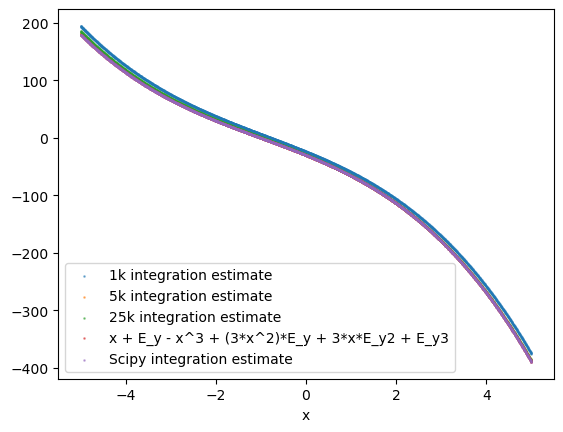

In [23]:
plt.scatter(x_vals, b_bar2_est_1k, label='1k integration estimate', s=0.8, alpha=0.5)
plt.scatter(x_vals, b_bar2_est_5k, label='5k integration estimate', s=0.8, alpha=0.5)
plt.scatter(x_vals, b_bar2_est_25k, label='25k integration estimate', s=0.8, alpha=0.5)
plt.scatter(x_vals, b_bar2_manual, label='x + E_y - x^3 + (3*x^2)*E_y + 3*x*E_y2 + E_y3', s=0.8, alpha=0.5)
plt.scatter(x_vals, b_bar2_est_scipy[:,0], label='Scipy integration estimate', s=0.8, alpha=0.5)
# plt.scatter(x_vals, x_vals-x_vals**3, label='x-x^3', s=0.8, alpha=0.5)
plt.xlabel('x')

plt.legend()
plt.show()

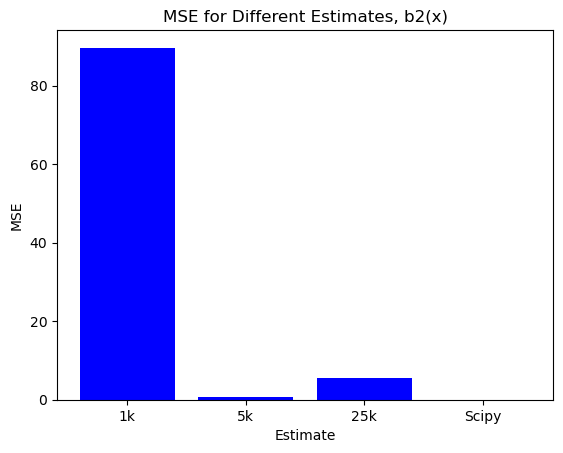

In [26]:

mse2_1k = mse(b_bar2_manual, b_bar2_est_1k)
mse2_5k = mse(b_bar2_manual, b_bar2_est_5k)
mse2_25k = mse(b_bar2_manual, b_bar2_est_25k)
mse2_scipy = mse(b_bar2_manual, b_bar2_est_scipy[:,0])

labels2 = ['1k', '5k', '25k', 'Scipy']
mse2_values = [mse2_1k, mse2_5k, mse2_25k, mse2_scipy]

plt.bar(labels2, mse2_values, color='blue')
plt.xlabel('Estimate')
plt.ylabel('MSE')
plt.title('MSE for Different Estimates, b2(x)')
plt.show()